<a href="https://colab.research.google.com/github/alswnsdlf/project4/blob/main/ai_06_project4_%EB%AF%BC%EC%A4%80%EC%9D%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** 증권사 혹은 은행에서 일을 할 계획이 있어서 주식 데이터로 이번 프로젝트를 진행하게 되었습니다. 코드 스테이츠에 등록하기 전부터 주식에 대한 관심이 많았고 실제로도 주식 투자에 대한 공부를 틈틈히 하고 있으며 현재 여러 기업들에 투자를 하고 있습니다. 주식 투자에 대해 공부를 할 때 문득 이런 의문점들을 갖게 되었습니다.

1. 주식 데이터는 수치화가 가능한 항목들만 나타낸 데이터인데 그 외 적인 것들(예를 들어, 정치적 상황이나 기업의 상황 등)에 대한 분석은 데이터 상에서 어떻게 나타내는지

2. 수치상의 데이터로 분석을 한다면 지금까지의 데이터로 미래에 대한 예측을 하는 것인데, 과거의 특정 시기와 미래의 특정 시기가 같다고 분석이 되는지 (과거와 미래 연도의 동일 월, 일)

3. 내가 주식 데이터를 기반으로 분석한 결과가 실제 주식 투자에 적용이 가능할지

4. 모델을 사용하여 분석한 결과는 어떤 상황에서 효율적으로 쓰일 수 있는지

이러한 의문점들을 해결하고자 혹은 추후에 해결될 수 있는지를 보고자 이번 프로젝트를 진행하였습니다.

In [1]:
!pip install -U finance-datareader

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
import datetime
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
import numpy as np
import FinanceDataReader as fdr
import keras
from datetime import datetime
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

tf.__version__, keras.__version__

('2.7.0', '2.7.0')

In [3]:
def cda(ticker = '035720', stt = '2016-01-01', end = '2021-01-01', history_points = 50):
    data = fdr.DataReader(ticker, stt, end)
    data = data.iloc[:,0:-1]
    print('data: ', data.shape)
    data = data.values
    data_normalizer = preprocessing.MinMaxScaler()
    data_normalized = data_normalizer.fit_transform(data)
    print('data_normalized: ', data_normalized.shape)

    df_stock_normalized = np.array([data_normalized[i:i + history_points].copy() for i in range(len(data_normalized) - history_points)]) # ohlcv를 가지고 오되, 관찰일수 만큼 누적해서 쌓는다. (열방향으로)
    
    print('df_stock_normalized: ', df_stock_normalized.shape)

    next_day_open_values_normalized = np.array([data_normalized[:, 0][i + history_points].copy() for i in range(len(data_normalized) - history_points)])
    next_day_open_values_normalized = np.expand_dims(next_day_open_values_normalized, -1) 

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1) 

    y_normalizer = preprocessing.MinMaxScaler()
    y_normalizer.fit(next_day_open_values)

    def vt(values, time_period):
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in df_stock_normalized:
        sma = np.mean(his[:, 3])
        macd = vt(his, 12) - vt(his, 26)
        technical_indicators.append(np.array([sma]))
    technical_indicators = np.array(technical_indicators)
    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalized = tech_ind_scaler.fit_transform(technical_indicators)
    technical_indicators = np.array(technical_indicators)
    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalized = tech_ind_scaler.fit_transform(technical_indicators)
    
    assert df_stock_normalized.shape[0] == next_day_open_values_normalized.shape[0] == technical_indicators_normalized.shape[0]

    print('df_stock_normalized.shape[0]: ', df_stock_normalized.shape[0])

    return df_stock_normalized, technical_indicators_normalized, next_day_open_values_normalized, next_day_open_values, y_normalizer

In [4]:
history_points = 50
ticker = '035720' # 카카오 데이터명
np.random.seed(44)
tensorflow.random.set_seed(44)
df_stock, _, next_day_open_values, unscaled_y, y_normaliser = cda(ticker=ticker)
train_r = 0.8
n = int(df_stock.shape[0] * train_r)
df_train = df_stock[-n:-1]
y_train = next_day_open_values[-n:-1]
df_test = df_stock[:df_stock.shape[0]-n]
y_test = next_day_open_values[:df_stock.shape[0]-n]
unscaled_y_test = unscaled_y[:df_stock.shape[0]-n]

print('훈련데이터: ', df_train.shape)
print('테스트데이터: ',df_test.shape)

data:  (1227, 5)
data_normalized:  (1227, 5)
df_stock_normalized:  (1177, 50, 5)
df_stock_normalized.shape[0]:  1177
훈련데이터:  (940, 50, 5)
테스트데이터:  (236, 50, 5)


In [5]:
df_train

array([[[0.02288313, 0.01666953, 0.02244292, 0.01819139, 0.00602218],
        [0.02115065, 0.01926161, 0.02335257, 0.02025328, 0.00803192],
        [0.02289757, 0.01868878, 0.02096661, 0.01643659, 0.01273553],
        ...,
        [0.05245073, 0.04887724, 0.05298319, 0.04930978, 0.05072165],
        [0.04954883, 0.04397949, 0.04728672, 0.04255381, 0.04310506],
        [0.04664694, 0.04082889, 0.04490076, 0.04138395, 0.06532274]],

       [[0.02115065, 0.01926161, 0.02335257, 0.02025328, 0.00803192],
        [0.02289757, 0.01868878, 0.02096661, 0.01643659, 0.01273553],
        [0.02026998, 0.01379103, 0.01855083, 0.01408224, 0.01904236],
        ...,
        [0.04954883, 0.04397949, 0.04728672, 0.04255381, 0.04310506],
        [0.04664694, 0.04082889, 0.04490076, 0.04138395, 0.06532274],
        [0.04520321, 0.03880965, 0.04370778, 0.04109148, 0.0477312 ]],

       [[0.02289757, 0.01868878, 0.02096661, 0.01643659, 0.01273553],
        [0.02026998, 0.01379103, 0.01855083, 0.01408224, 0.0

In [6]:
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)
adam = tf.optimizers.Adam(lr=0.01)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
model.compile(optimizer=adam, loss='mse')
model.fit(x=df_train, y=y_train, batch_size=40, epochs=100, shuffle=True, validation_split=0.1)
y_test_predicted = model.predict(df_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(df_stock)
y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)
model.save(f'basic_model.h5')

Epoch 1/100
22/22 [==============================] - 3s 50ms/step - loss: 0.0497 - val_loss: 0.0058
Epoch 2/100
22/22 [==============================] - 1s 26ms/step - loss: 0.0019 - val_loss: 0.0051
Epoch 3/100
22/22 [==============================] - 1s 26ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 4/100
22/22 [==============================] - 1s 26ms/step - loss: 9.8627e-04 - val_loss: 0.0043
Epoch 5/100
22/22 [==============================] - 1s 25ms/step - loss: 9.9307e-04 - val_loss: 9.5724e-04
Epoch 6/100
22/22 [==============================] - 1s 26ms/step - loss: 8.5420e-04 - val_loss: 0.0046
Epoch 7/100
22/22 [==============================] - 1s 25ms/step - loss: 8.7008e-04 - val_loss: 0.0014
Epoch 8/100
22/22 [==============================] - 1s 27ms/step - loss: 6.9617e-04 - val_loss: 5.9330e-04
Epoch 9/100
22/22 [==============================] - 1s 25ms/step - loss: 5.2620e-04 - val_loss: 0.0064
Epoch 10/100
22/22 [==============================] - 1s 26ms/step -

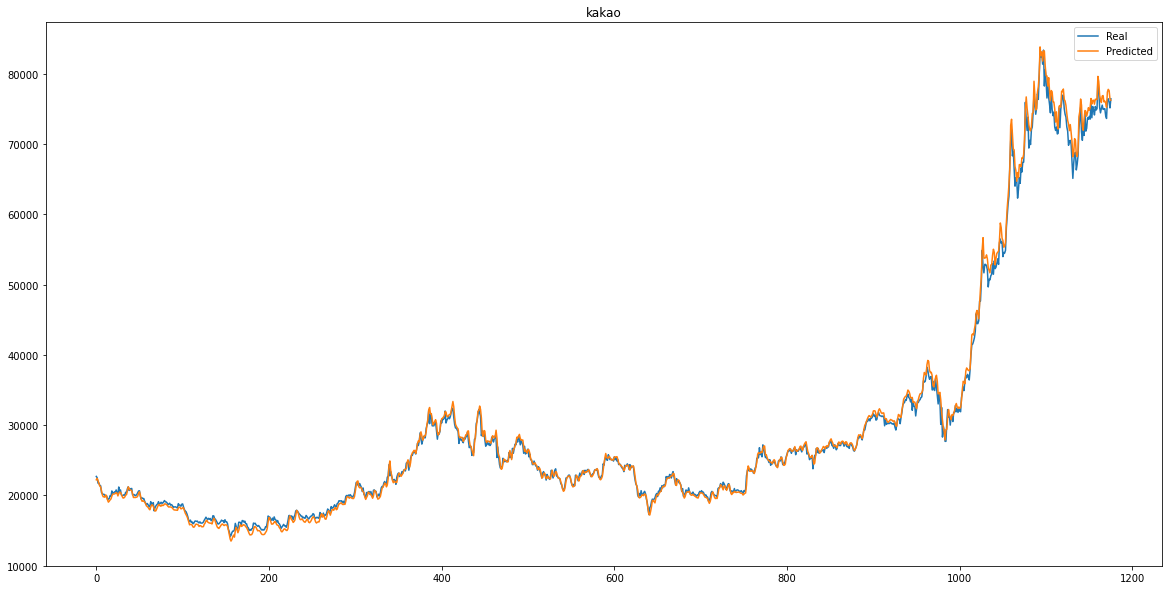

In [11]:
plt.gcf().set_size_inches(20, 10, forward=True)
start = 0
end = -1
real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')
plt.legend(['Real', 'Predicted'])
plt.title('kakao')
plt.show()

In [9]:
col_name = ['real', 'pred']
real, pred = pd.DataFrame(unscaled_y[start:end]), pd.DataFrame(y_predicted[start:end])
real_pred = pd.concat([real, pred], axis = 1)
real_pred.columns = col_name

In [10]:
real_pred

,real,pred
0,22700,22216.615234
1,22519,22415.710938
2,21737,22105.519531
3,21777,21697.279297
4,21395,21357.916016
...,...,...
1171,76270,77421.453125
1172,76471,77808.328125
1173,75971,77632.062500
1174,75168,76419.398438
